In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px

In [4]:
df = pd.read_csv("updated_dataset.csv")

In [5]:
df.head()

,Agency,Commendation or Complaint,Subject Matter,Subject Detail,Issue Detail,Year,Quarter,Branch/Line/Route
0,Buses,Commendation,Employee,Bus Operator / Driver,Customer Service / Behavior,2019,4,B67
1,Buses,Commendation,Employee,Bus Operator / Driver,Customer Service / Behavior,2019,4,SIM33C
2,Buses,Commendation,Employee,Bus Operator / Driver,Customer Service / Behavior,2019,4,B8
3,Buses,Commendation,Employee,Bus Operator / Driver,Customer Service / Behavior,2019,4,BM4
4,Buses,Commendation,Employee,Bus Operator / Driver,Customer Service / Behavior,2019,4,Q46


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193762 entries, 0 to 193761
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Agency                     193762 non-null  object
 1   Commendation or Complaint  193762 non-null  object
 2   Subject Matter             193762 non-null  object
 3   Subject Detail             193762 non-null  object
 4   Issue Detail               193762 non-null  object
 5   Year                       193762 non-null  int64 
 6   Quarter                    193762 non-null  int64 
 7   Branch/Line/Route          193762 non-null  object
dtypes: int64(2), object(6)
memory usage: 11.8+ MB


In [7]:
df.shape

(193762, 8)

In [8]:
missing_values = df.isnull().sum()
missing_values_percentage = (df.isnull().sum() / len(df)) * 100

missing_values

Agency                       0
Commendation or Complaint    0
Subject Matter               0
Subject Detail               0
Issue Detail                 0
Year                         0
Quarter                      0
Branch/Line/Route            0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [17]:
missing_values = df.isnull().sum()
missing_values_percentage = (df.isnull().sum() / len(df)) * 100

missing_values

Agency                       0
Commendation or Complaint    0
Subject Matter               0
Subject Detail               0
Issue Detail                 0
Year                         0
Quarter                      0
Branch/Line/Route            0
dtype: int64

C:\Users\thisi\AppData\Local\Temp\ipykernel_24184\752963887.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data.groupby('Branch/Line/Route', group_keys=False)


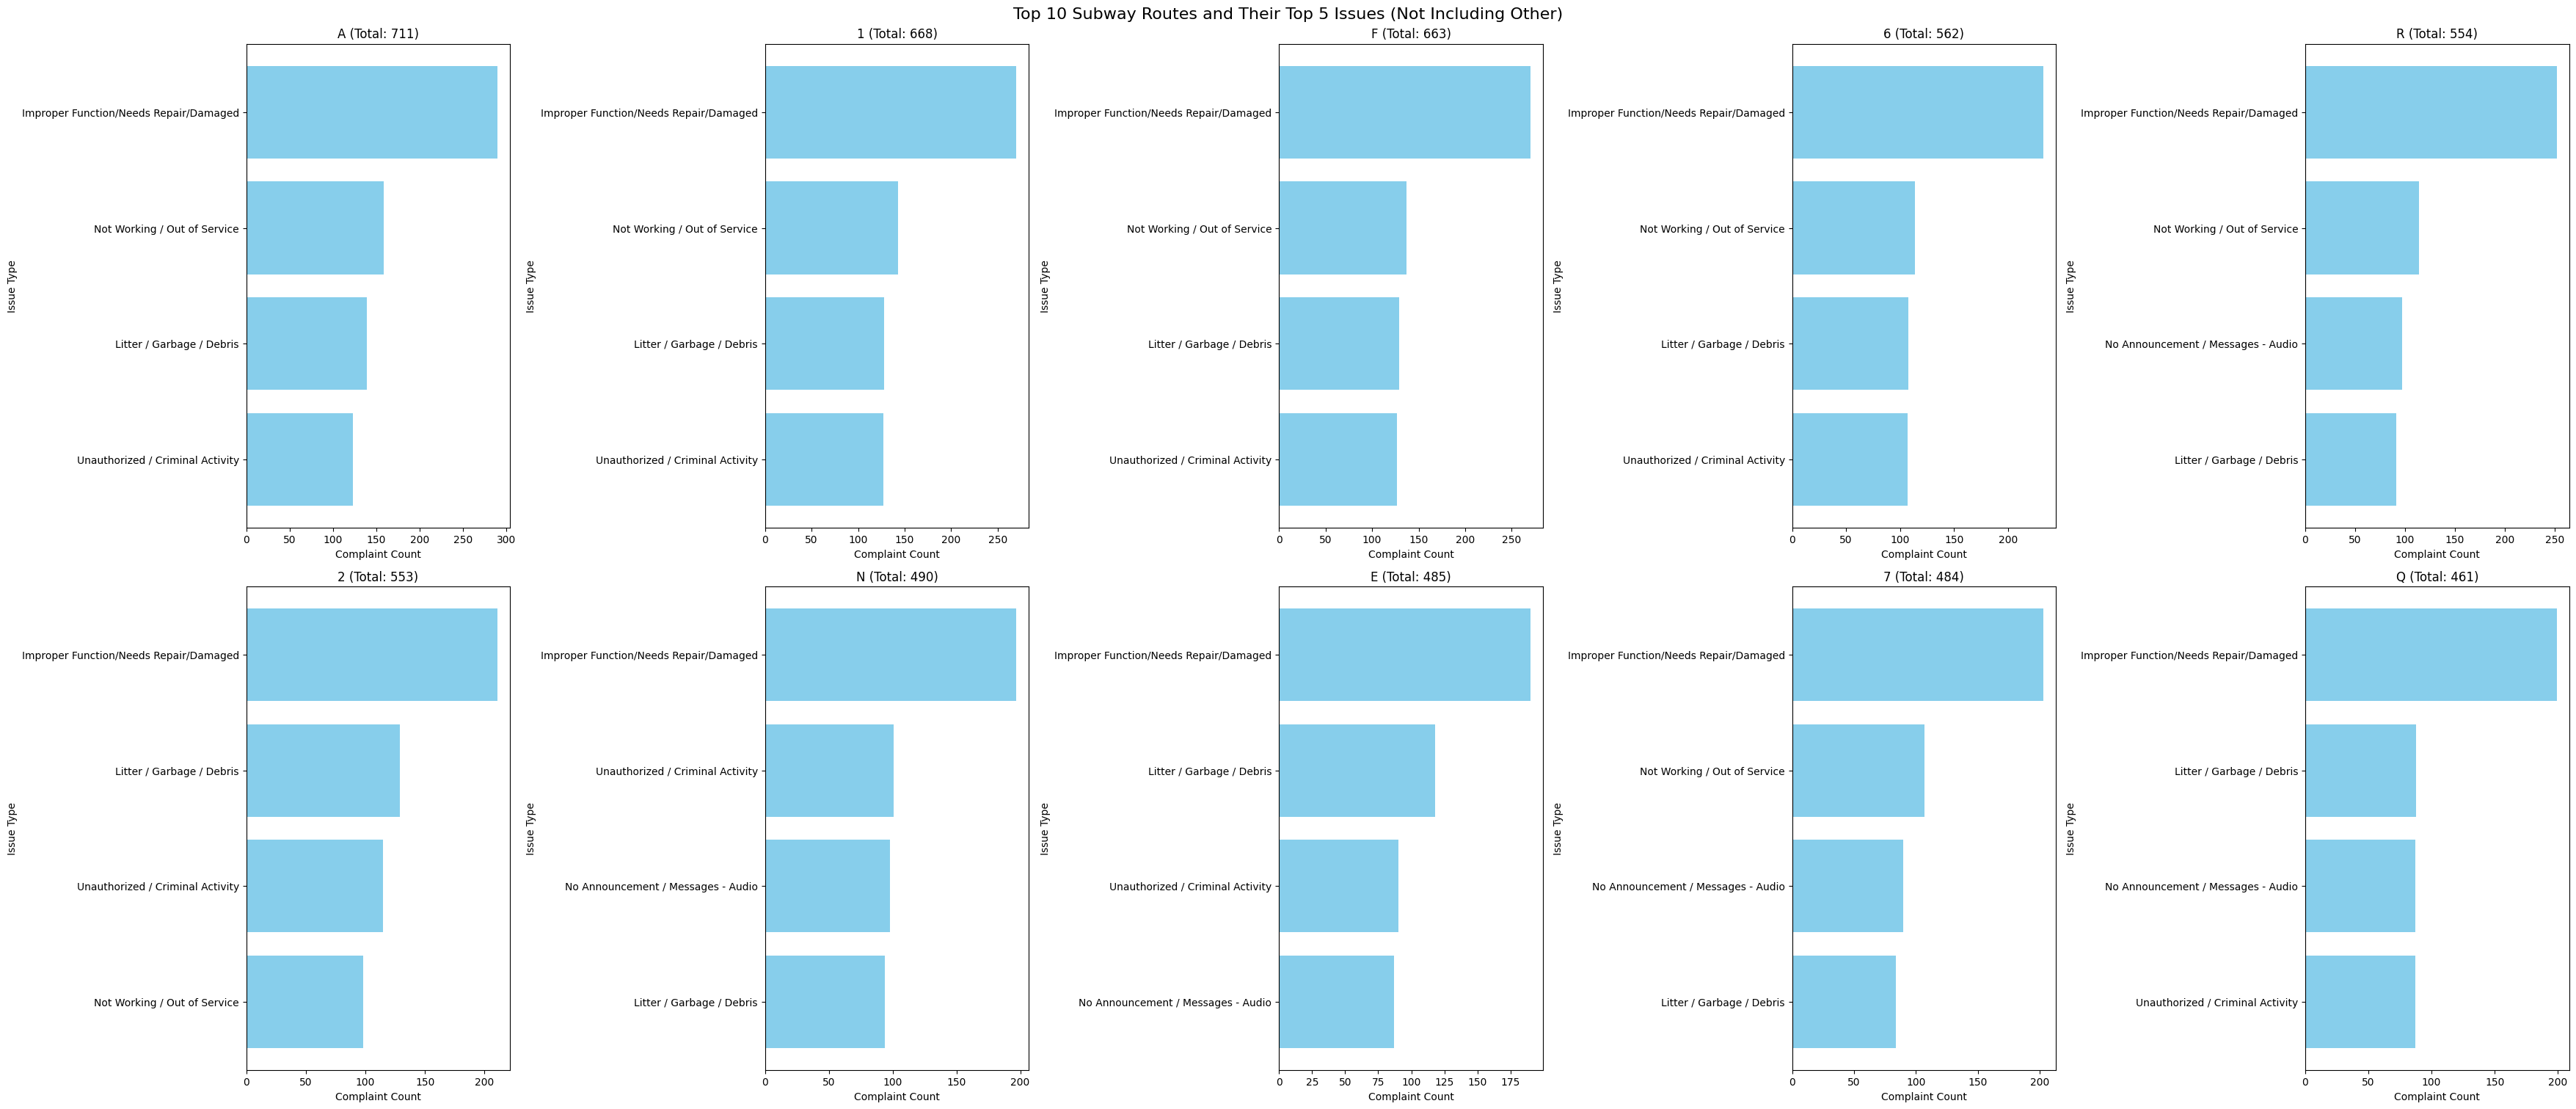

In [42]:
# Filter data for subways as the train routes
train_data = df[df['Agency'] == 'Subways']

# Drop NaN Branch/Line/Route's
train_data = train_data.dropna(subset=['Branch/Line/Route'])
train_data = train_data[train_data['Branch/Line/Route'] != 'No Value']

# Group by Branch/Line/Route and Issue Detail to get counts
top_issues = (
    train_data.groupby(['Branch/Line/Route', 'Issue Detail'])
    .size()
    .reset_index(name='Count')
)

# Get top 10 subway routes by total complaint count
top_routes = (
    top_issues.groupby('Branch/Line/Route')['Count']
    .sum()
    .nlargest(10)
    .index
)

# Filter for top routes and get top 5 issues for each route
filtered_data = top_issues[top_issues['Branch/Line/Route'].isin(top_routes)]

# Get the top 5 issues for each route
top_5_issues = (
    filtered_data.groupby('Branch/Line/Route', group_keys=False)
    .apply(lambda x: x.nlargest(5, 'Count'))
    .reset_index(drop=True)
)

# Remove "Other" category
top_5_issues = top_5_issues[top_5_issues['Issue Detail'] != 'Other']

# Ensure proper data types
top_5_issues['Count'] = top_5_issues['Count'].astype(int)
top_5_issues['Issue Detail'] = top_5_issues['Issue Detail'].astype(str)
top_5_issues['Branch/Line/Route'] = top_5_issues['Branch/Line/Route'].astype(str)

# Compute total complaints for each route
route_totals = top_5_issues.groupby('Branch/Line/Route')['Count'].sum()

# Sort routes by total complaints
routes_sorted = route_totals.sort_values(ascending=False).index

# Set up subplots
n_cols = 5
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, n_rows * 7.5), constrained_layout=True)

axes = axes.flatten()

# Plot data for each route
for i, route in enumerate(routes_sorted):
    route_data = top_5_issues[top_5_issues['Branch/Line/Route'] == route]
    ax = axes[i]
    ax.barh(route_data['Issue Detail'], route_data['Count'], color='skyblue')
    ax.set_title(f"{route} (Total: {route_totals[route]})", fontsize=12)
    ax.set_xlabel("Complaint Count")
    ax.set_ylabel("Issue Type")
    ax.invert_yaxis()

# Hide unused subplots
for i in range(len(routes_sorted), len(axes)):
    axes[i].axis('off')


fig.suptitle("Top 10 Subway Routes and Their Top 5 Issues (Not Including Other)", fontsize=16)
output_path = "graph2.png"
plt.savefig(output_path, format='png', dpi=300)
plt.show()